# Gerando uma representação em tokens do arquivo MIDI para visualização

Neste notebook, estamos convertendo um arquivo MIDI em uma sequência de tokens usando o tokenizer MIDILike da biblioteca miditok. 
Esta tokenização nos permite:

1. Representar eventos musicais (notas, velocidades, programas) como tokens discretos
2. Visualizar a estrutura temporal da música
3. Analisar padrões e características da composição

A seguir, veremos diferentes visualizações desses tokens para melhor compreender a estrutura da música.


In [ ]:
import miditok
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pretty_midi


# Carregar o MIDI
midi_data = pretty_midi.PrettyMIDI("rockylutador.mid")

# Pegar eventos de tempo
tempo_changes = midi_data.get_tempo_changes()
tempos = tempo_changes[1]  # Array com os tempos em microsegs/beat

# Converter para BPM
bpms = [60000000 / tempo for tempo in tempos]

print("=== Tempos do MIDI ===")
print(f"Número de mudanças de tempo: {len(bpms)}")
if bpms:
    print(f"BPM inicial: {bpms[0]:.1f}")
    print(f"BPM mínimo: {min(bpms):.1f}")
    print(f"BPM máximo: {max(bpms):.1f}")
    print(f"BPM médio: {sum(bpms)/len(bpms):.1f}")

bpm = max(bpms)
# Carregar o arquivo MIDI
midi_path = "rockylutador.mid"

# Configurar o tokenizer MIDILike usando TokenizerConfig
config = miditok.TokenizerConfig(
    pitch_range=(21, 109),
    beat_res={(1, 4): 8},  # 8 ticks por beat
    nb_velocities=32,
    additional_tokens={'Tempo', 'Program'},
    use_programs=True
)
tokenizer = miditok.MIDILike(config)

# Tokenizar o MIDI e fazer debug
tokens = tokenizer(Path(midi_path))
print("=== Debug Tokens ===")
print("Tipo dos tokens:", type(tokens))

if isinstance(tokens, (list, tuple)):
    print("\nPrimeiro elemento dos tokens:", tokens[0])
    if len(tokens) > 0:
        print("Tipo do primeiro elemento:", type(tokens[0]))
        if isinstance(tokens[0], (list, tuple)):
            print("Primeiros 5 tokens do primeiro elemento:", tokens[0][:5])
            print("Tipo do primeiro token:", type(tokens[0][0]))
else:
    print("\nTokens não é uma lista/tupla")
    print("Tentando acessar atributos/métodos do objeto tokens:")
    print("Dir(tokens):", dir(tokens))

# Vamos tentar entender a estrutura do tokenizer também
print("\n=== Debug Tokenizer ===")
print("Atributos do tokenizer:", dir(tokenizer))
print("\nVocabulário do tokenizer:")
if hasattr(tokenizer, 'vocab'):
    print(tokenizer.vocab)
elif hasattr(tokenizer, 'vocab_size'):
    print("Tamanho do vocabulário:", tokenizer.vocab_size)


=== Tempos do MIDI ===
Número de mudanças de tempo: 2
BPM inicial: 618556.0
BPM mínimo: 618556.0
BPM máximo: 659340.0
BPM médio: 638948.0


/var/folders/qc/40cp3vzn26dgkntppc0jv9tc0000gn/T/ipykernel_17157/1922382867.py:31: UserWarning: Argument nb_velocities has been renamed num_velocities, you should consider to updateyour code with this new argument name.
  config = miditok.TokenizerConfig(
/var/folders/qc/40cp3vzn26dgkntppc0jv9tc0000gn/T/ipykernel_17157/1922382867.py:38: UserWarning: Attribute controls are not compatible with 'config.one_token_stream_for_programs' and multi-vocabulary tokenizers. Disabling them from the config.
  tokenizer = miditok.MIDILike(config)


=== Debug Tokens ===
Tipo dos tokens: <class 'miditok.classes.TokSequence'>

Tokens não é uma lista/tupla
Tentando acessar atributos/métodos do objeto tokens:
Dir(tokens): ['_TokSequence__slice', '__add__', '__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_ids_decoded', '_split_per_ticks', '_ticks_bars', '_ticks_beats', 'are_ids_encoded', 'bytes', 'events', 'ids', 'split_per_bars', 'split_per_beats', 'tokens']

=== Debug Tokenizer ===
Atributos do tokenizer: ['_MusicTokenizer__convert_resampling_ratios_ticks_to_idx', '_MusicTokenizer__create_pitch_bends', '_MusicTokenizer__create_

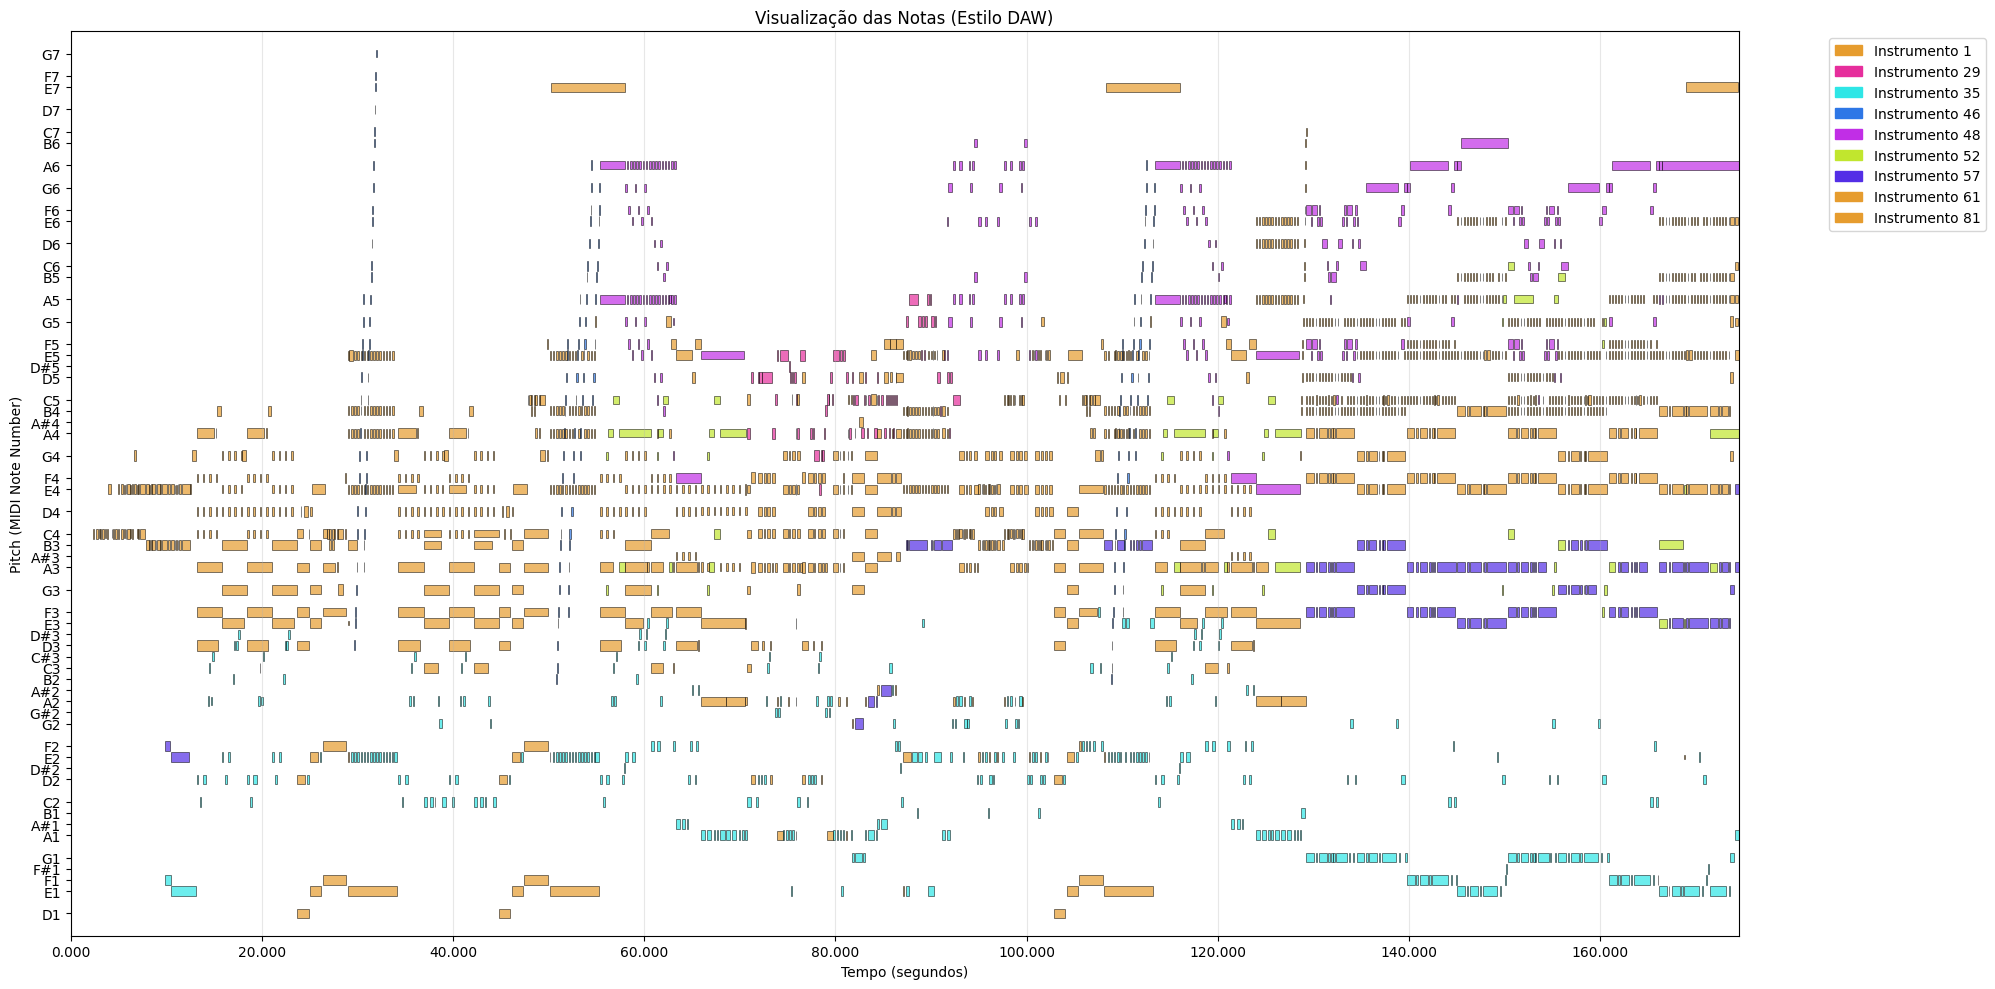


=== Estatísticas das Notas ===
Total de notas: 2781
Número de instrumentos diferentes: 9
Duração total da música: 174.478 segundos

Range de notas:
Nota mais baixa: D1 (MIDI 26)
Nota mais alta: G7 (MIDI 103)

Distribuição de notas por instrumento:
Instrumento 1: 1283 notas, duração média: 0.295 segundos
Instrumento 29: 78 notas, duração média: 0.211 segundos
Instrumento 35: 381 notas, duração média: 0.265 segundos
Instrumento 46: 158 notas, duração média: 0.089 segundos
Instrumento 48: 278 notas, duração média: 0.406 segundos
Instrumento 52: 58 notas, duração média: 0.723 segundos
Instrumento 57: 134 notas, duração média: 0.566 segundos
Instrumento 61: 405 notas, duração média: 0.430 segundos
Instrumento 81: 6 notas, duração média: 3.571 segundos


In [64]:
# Criar visualização estilo DAW usando os eventos e convertendo tempo para segundos
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import colorsys

# Pegar o time division do tokenizer
TICKS_PER_BEAT = tokenizer.time_division  # Ticks por beat (normalmente 480)
DEFAULT_TEMPO = bpm # Microssegundos por beat (120 BPM é o padrão)

def ticks_to_seconds(ticks):
    """Converte ticks para segundos usando o tempo padrão"""
    beats = ticks / TICKS_PER_BEAT
    seconds = (beats * DEFAULT_TEMPO) / 1_000_000  # Converter microssegundos para segundos
    return seconds

# Estrutura para armazenar informações das notas
class Note:
    def __init__(self, pitch, start_time, velocity=None, program=None):
        self.pitch = pitch
        self.start_ticks = start_time
        self.end_ticks = None
        self.velocity = velocity
        self.program = program
        
    @property
    def start_time(self):
        return ticks_to_seconds(self.start_ticks)
        
    @property
    def end_time(self):
        return ticks_to_seconds(self.end_ticks) if self.end_ticks is not None else None
        
    @property
    def duration(self):
        return self.end_time - self.start_time if self.end_time is not None else None

# Processar os eventos para extrair as notas
active_notes = {}  # pitch -> Note
completed_notes = []

# Processar cada evento para construir as notas
for event in tokens.events:
    if event.type_ == 'NoteOn':
        pitch = event.value
        program = event.program
        
        # Procurar a velocidade no próximo evento
        idx = tokens.events.index(event)
        velocity = None
        if idx + 1 < len(tokens.events) and tokens.events[idx + 1].type_ == 'Velocity':
            velocity = tokens.events[idx + 1].value
        
        if pitch not in active_notes:  # Ignorar se a nota já está ativa
            active_notes[pitch] = Note(pitch, event.time, velocity, program)
            
    elif event.type_ == 'NoteOff':
        pitch = event.value
        if pitch in active_notes:  # Só processar se a nota está ativa
            note = active_notes[pitch]
            note.end_ticks = event.time
            if note.end_ticks > note.start_ticks:  # Só adicionar se a nota tem duração positiva
                completed_notes.append(note)
            del active_notes[pitch]

# Criar o gráfico
plt.figure(figsize=(20, 10))

def get_program_color(program):
    # Criar cores distintas para diferentes programas
    hue = (program * 0.1) % 1.0
    return colorsys.hsv_to_rgb(hue, 0.8, 0.9)

# Ordenar as notas por pitch para melhor visualização
completed_notes.sort(key=lambda x: x.pitch)

# Criar as barras para cada nota
for note in completed_notes:
    color = get_program_color(note.program)
    # Ajustar a altura da barra baseado na velocidade
    height = 0.8
    if note.velocity:
        height = 0.3 + (note.velocity / 127) * 0.7  # velocidade afeta a altura da barra
    
    # Criar um retângulo para cada nota
    rect = patches.Rectangle(
        (note.start_time, note.pitch - height/2),
        note.duration,
        height,
        facecolor=color,
        alpha=0.7,
        edgecolor='black',
        linewidth=0.5
    )
    plt.gca().add_patch(rect)

# Configurar o gráfico
plt.grid(True, alpha=0.3, axis='x')
plt.xlabel('Tempo (segundos)')
plt.ylabel('Pitch (MIDI Note Number)')

# Adicionar rótulos do piano no eixo y
piano_notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
def midi_to_note(midi_num):
    note = piano_notes[midi_num % 12]
    octave = (midi_num // 12) - 1
    return f"{note}{octave}"

# Obter todos os pitches únicos
all_pitches = sorted(list(set(note.pitch for note in completed_notes)))
plt.yticks(all_pitches, [midi_to_note(p) for p in all_pitches])

# Ajustar os limites do gráfico
if completed_notes:
    plt.xlim(0, max(note.end_time for note in completed_notes))
    plt.ylim(min(all_pitches) - 2, max(all_pitches) + 2)

# Configurar o formato dos ticks do eixo x para mostrar milissegundos
from matplotlib.ticker import FuncFormatter

def format_time(x, p):
    return f"{x:.3f}"  # Formato com 3 casas decimais para milissegundos

plt.gca().xaxis.set_major_formatter(FuncFormatter(format_time))

plt.title('Visualização das Notas (Estilo DAW)')

# Adicionar uma legenda com os programas (instrumentos)
program_patches = []
unique_programs = sorted(list(set(note.program for note in completed_notes)))
for program in unique_programs:
    color = get_program_color(program)
    program_patches.append(patches.Patch(color=color, label=f'Instrumento {program}'))
plt.legend(handles=program_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar o layout para não cortar a legenda
plt.tight_layout()

plt.show()

# Imprimir algumas estatísticas
print("\n=== Estatísticas das Notas ===")
print(f"Total de notas: {len(completed_notes)}")
print(f"Número de instrumentos diferentes: {len(unique_programs)}")
print(f"Duração total da música: {max(note.end_time for note in completed_notes):.3f} segundos")
print("\nRange de notas:")
print(f"Nota mais baixa: {midi_to_note(min(all_pitches))} (MIDI {min(all_pitches)})")
print(f"Nota mais alta: {midi_to_note(max(all_pitches))} (MIDI {max(all_pitches)})")

# Mostrar distribuição de notas por instrumento
print("\nDistribuição de notas por instrumento:")
for program in unique_programs:
    notes = [n for n in completed_notes if n.program == program]
    count = len(notes)
    if count > 0:
        avg_duration = sum(n.duration for n in notes) / count
        print(f"Instrumento {program}: {count} notas, duração média: {avg_duration:.3f} segundos")


In [ ]:
def plot_midi_piano_roll(tokens, start_time_seconds=0, end_time_seconds=None, bpm=500000, figsize=(20, 10)):
    """
    Plota um piano roll do MIDI em um intervalo de tempo específico.
    
    Args:
        tokens: objeto TokSequence do miditok
        start_time_seconds: tempo inicial em segundos (default: 0)
        end_time_seconds: tempo final em segundos (default: None, mostra até o final)
        figsize: tupla com tamanho da figura (width, height)
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import colorsys
    from matplotlib.ticker import FuncFormatter
    
    # Pegar o time division do tokenizer
    TICKS_PER_BEAT = tokenizer.time_division
    DEFAULT_TEMPO = bpm  # Microssegundos por beat (120 BPM)
    
    def ticks_to_seconds(ticks):
        beats = ticks / TICKS_PER_BEAT
        seconds = (beats * DEFAULT_TEMPO) / 1_000_000
        return seconds
    
    class Note:
        def __init__(self, pitch, start_time, velocity=None, program=None):
            self.pitch = pitch
            self.start_ticks = start_time
            self.end_ticks = None
            self.velocity = velocity
            self.program = program
            
        @property
        def start_time(self):
            return ticks_to_seconds(self.start_ticks)
            
        @property
        def end_time(self):
            return ticks_to_seconds(self.end_ticks) if self.end_ticks is not None else None
            
        @property
        def duration(self):
            return self.end_time - self.start_time if self.end_time is not None else None
    
    # Processar os eventos para extrair as notas
    active_notes = {}  # pitch -> Note
    completed_notes = []
    
    # Processar cada evento para construir as notas
    for event in tokens.events:
        if event.type_ == 'NoteOn':
            pitch = event.value
            program = event.program
            
            # Procurar a velocidade no próximo evento
            idx = tokens.events.index(event)
            velocity = None
            if idx + 1 < len(tokens.events) and tokens.events[idx + 1].type_ == 'Velocity':
                velocity = tokens.events[idx + 1].value
            
            if pitch not in active_notes:  # Ignorar se a nota já está ativa
                active_notes[pitch] = Note(pitch, event.time, velocity, program)
                
        elif event.type_ == 'NoteOff':
            pitch = event.value
            if pitch in active_notes:  # Só processar se a nota está ativa
                note = active_notes[pitch]
                note.end_ticks = event.time
                if note.end_ticks > note.start_ticks:  # Só adicionar se a nota tem duração positiva
                    completed_notes.append(note)
                del active_notes[pitch]
    
    # Filtrar notas pelo intervalo de tempo desejado
    if end_time_seconds is None:
        end_time_seconds = max(note.end_time for note in completed_notes)
    
    visible_notes = [
        note for note in completed_notes
        if (note.end_time >= start_time_seconds and note.start_time <= end_time_seconds)
    ]
    
    if not visible_notes:
        print(f"Nenhuma nota encontrada no intervalo de {start_time_seconds:.3f}s a {end_time_seconds:.3f}s")
        return
    
    # Criar o gráfico
    plt.figure(figsize=figsize)
    
    def get_program_color(program):
        hue = (program * 0.1) % 1.0
        return colorsys.hsv_to_rgb(hue, 0.8, 0.9)
    
    # Criar as barras para cada nota
    for note in visible_notes:
        color = get_program_color(note.program)
        height = 0.8
        if note.velocity:
            height = 0.3 + (note.velocity / 127) * 0.7
        
        # Ajustar o início e fim da nota ao intervalo visível
        visible_start = max(note.start_time, start_time_seconds)
        visible_end = min(note.end_time, end_time_seconds)
        
        rect = patches.Rectangle(
            (visible_start, note.pitch - height/2),
            visible_end - visible_start,
            height,
            facecolor=color,
            alpha=0.7,
            edgecolor='black',
            linewidth=0.5
        )
        plt.gca().add_patch(rect)
    
    # Configurar o gráfico
    plt.grid(True, alpha=0.3, axis='x')
    plt.xlabel('Tempo (segundos)')
    plt.ylabel('Pitch (MIDI Note Number)')
    
    # Adicionar rótulos do piano
    piano_notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    def midi_to_note(midi_num):
        note = piano_notes[midi_num % 12]
        octave = (midi_num // 12) - 1
        return f"{note}{octave}"
    
    # Obter todos os pitches únicos no intervalo visível
    all_pitches = sorted(list(set(note.pitch for note in visible_notes)))
    plt.yticks(all_pitches, [midi_to_note(p) for p in all_pitches])
    
    # Ajustar os limites do gráfico
    plt.xlim(start_time_seconds, end_time_seconds)
    plt.ylim(min(all_pitches) - 2, max(all_pitches) + 2)
    
    # Configurar o formato dos ticks do eixo x
    def format_time(x, p):
        return f"{x:.3f}"
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_time))
    
    plt.title(f'Visualização das Notas ({start_time_seconds:.3f}s - {end_time_seconds:.3f}s)')
    
    # Adicionar legenda
    program_patches = []
    unique_programs = sorted(list(set(note.program for note in visible_notes)))
    for program in unique_programs:
        color = get_program_color(program)
        program_patches.append(patches.Patch(color=color, label=f'Instrumento {program}'))
    plt.legend(handles=program_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir estatísticas do intervalo
    print(f"\n=== Estatísticas ({start_time_seconds:.3f}s - {end_time_seconds:.3f}s) ===")
    print(f"Notas visíveis: {len(visible_notes)}")
    print(f"Instrumentos ativos: {len(unique_programs)}")
    
    print("\nDistribuição de notas por instrumento:")
    for program in unique_programs:
        notes = [n for n in visible_notes if n.program == program]
        count = len(notes)
        if count > 0:
            avg_duration = sum(
                min(n.end_time, end_time_seconds) - max(n.start_time, start_time_seconds)
                for n in notes
            ) / count
            print(f"Instrumento {program}: {count} notas, duração média: {avg_duration:.3f} segundos")


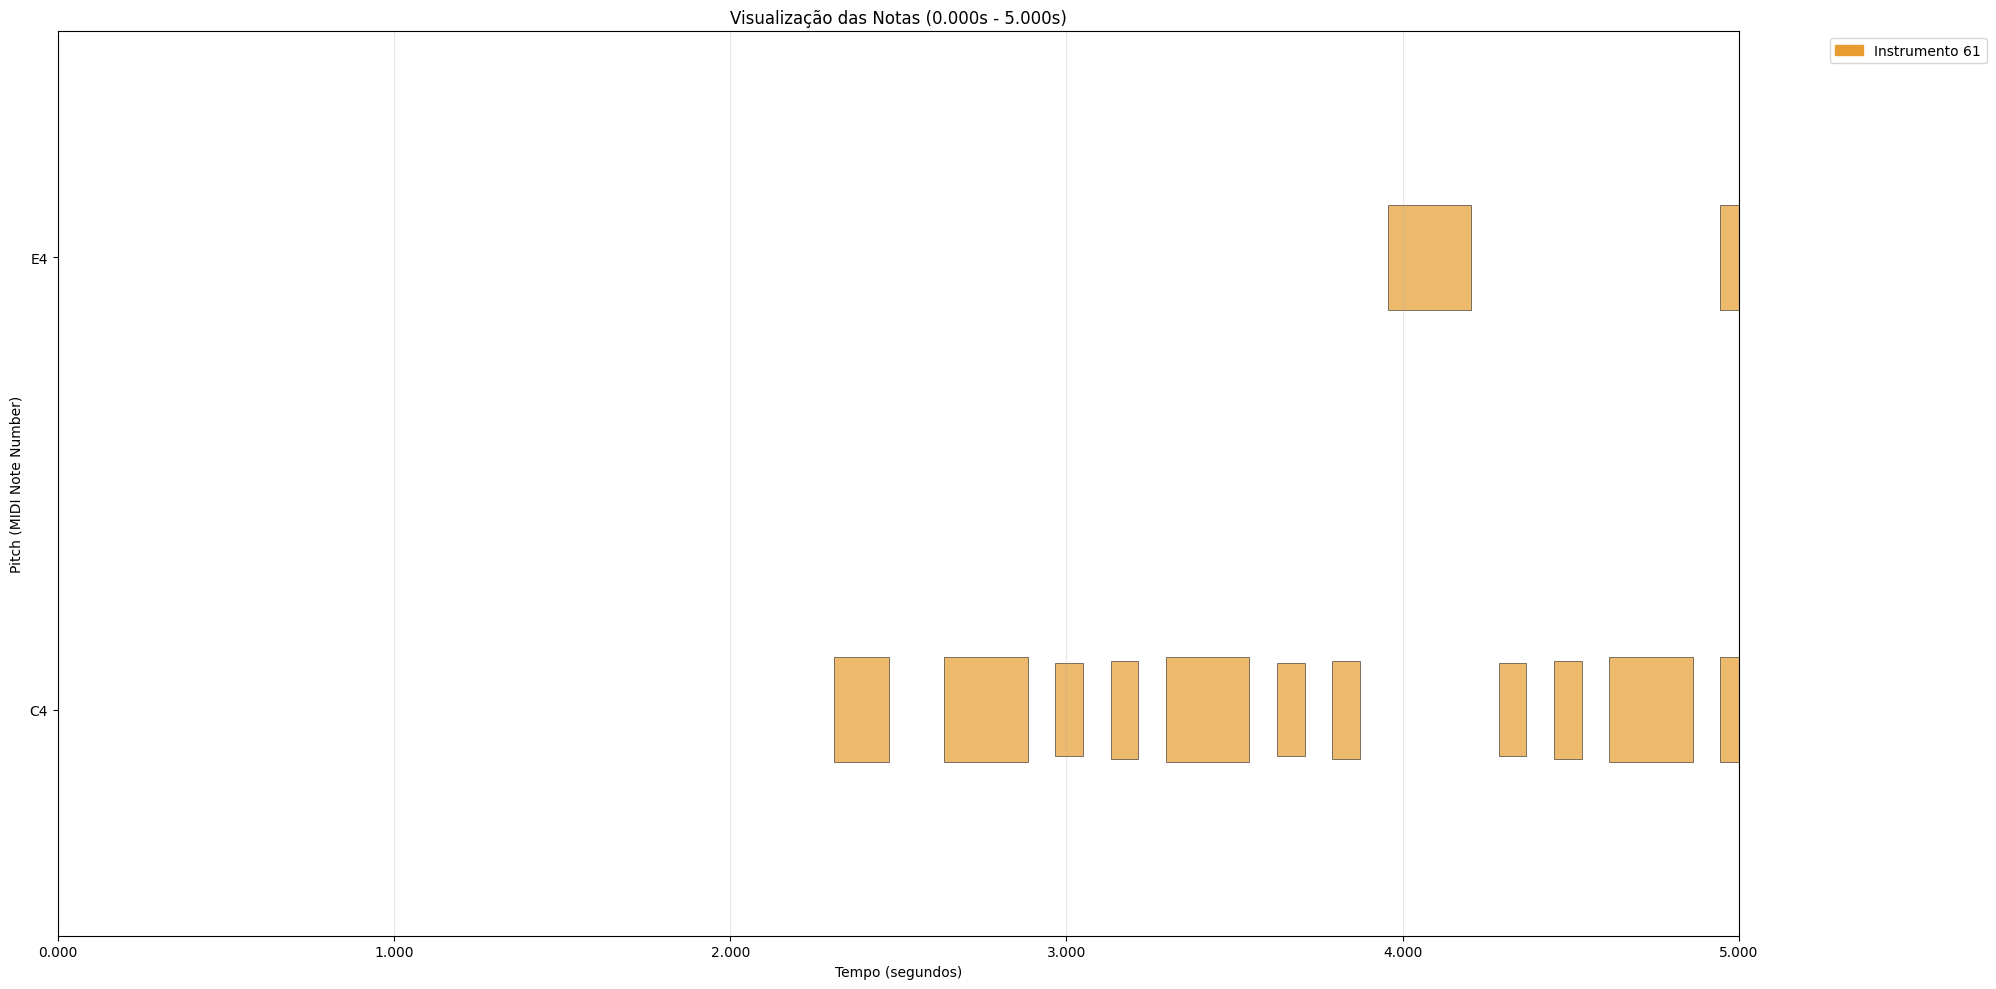


=== Estatísticas (0.000s - 5.000s) ===
Notas visíveis: 13
Instrumentos ativos: 1

Distribuição de notas por instrumento:
Instrumento 61: 13 notas, duração média: 0.135 segundos


In [ ]:
# Exemplo de uso: mostrar o primeiro segundo da música
plot_midi_piano_roll(tokens, start_time_seconds=0, end_time_seconds=5.0, bpm=bpm)



# Plotando CQT do Áudio junto com Tokens MIDI

Nesta seção, vamos visualizar o espectrograma CQT (Constant-Q Transform) do áudio alinhado com a representação MIDI em piano roll. Isso nos permite comparar visualmente como as notas MIDI se relacionam com o conteúdo espectral do áudio original.

O CQT é especialmente útil para análise musical pois:
- Usa uma escala logarítmica de frequências, similar à percepção humana
- Mantém resolução constante em termos de semitons
- Facilita a visualização de estruturas harmônicas

A visualização combinada nos ajuda a:
- Verificar o alinhamento entre MIDI e áudio
- Identificar possíveis discrepâncias na transcrição
- Analisar a distribuição de energia nas diferentes faixas de frequência


In [67]:
def plot_cqt_and_midi(cqt_path, tokens, start_time_seconds=0, end_time_seconds=None, figsize=(20, 12)):
    """
    Plota o CQT pré-calculado (.npy) alinhado com o piano roll MIDI.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import librosa
    import colorsys
    import os
    from matplotlib.ticker import FuncFormatter, LogLocator, AutoMinorLocator
    from matplotlib.gridspec import GridSpec
    
    def midi_to_note_name(midi_num):
        """Converte número MIDI para nome da nota"""
        NOTES = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
        note = NOTES[midi_num % 12]
        octave = (midi_num // 12) - 1
        return f"{note}{octave}"
    
    # Carregar o CQT
    C_db = np.load(cqt_path)
    
    # Parâmetros do CQT
    sr = 22050
    hop_length = 512
    n_bins_per_octave = 12
    n_octaves = 7
    fmin = librosa.midi_to_hz(21)  # A0
    
    # Calcular os tempos do CQT
    times = np.arange(C_db.shape[1]) * hop_length / sr
    
    # Se end_time não foi especificado, usar o tempo total do CQT
    if end_time_seconds is None:
        end_time_seconds = times[-1]
    
    # Encontrar os índices do CQT para o intervalo de tempo desejado
    start_idx = max(0, np.searchsorted(times, start_time_seconds))
    end_idx = min(len(times), np.searchsorted(times, end_time_seconds))
    
    # Ajustar os tempos de início e fim para corresponder aos frames do CQT
    start_time_seconds = times[start_idx]
    end_time_seconds = times[end_idx-1]
    
    # Criar a figura com GridSpec para melhor controle do layout
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 1.5], width_ratios=[19, 1])
    
    # Criar os subplots
    ax1 = fig.add_subplot(gs[0, 0])  # CQT
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)  # Piano roll
    cax = fig.add_subplot(gs[0, 1])  # Colorbar
    
    # Calcular frequências para o eixo y
    freqs = librosa.cqt_frequencies(
        n_bins=n_bins_per_octave * n_octaves,
        fmin=fmin,
        bins_per_octave=n_bins_per_octave
    )
    
    # Plot do CQT
    img = librosa.display.specshow(
        C_db[:, start_idx:end_idx],
        x_coords=times[start_idx:end_idx],
        y_coords=freqs,
        ax=ax1,
        x_axis=None,
        y_axis='cqt_hz',
        cmap='magma'
    )
    
    # Configurar o eixo x do CQT manualmente
    def format_time(x, p):
        return f"{x:.2f}s"
    
    ax1.xaxis.set_major_formatter(FuncFormatter(format_time))
    ax1.xaxis.set_major_locator(plt.MaxNLocator(10))  # Ajustar número de ticks
    ax1.xaxis.set_minor_locator(AutoMinorLocator())  # Adicionar ticks menores
    ax1.set_xlabel('Tempo (segundos)')
    
    # Adicionar colorbar e título
    fig.colorbar(img, cax=cax, format="%+2.f dB")
    cqt_filename = os.path.basename(cqt_path)
    ax1.set_title(f'Constant-Q Transform - {cqt_filename}')
    
    # Garantir que os limites do eixo x estejam corretos para o CQT
    ax1.set_xlim(start_time_seconds, end_time_seconds)
    
    # Plot do piano roll
    def plot_piano_roll(ax, tokens, start_time_seconds, end_time_seconds):
        # Pegar o time division do tokenizer
        TICKS_PER_BEAT = tokenizer.time_division
        DEFAULT_TEMPO = bpm  # Microssegundos por beat 
        
        def ticks_to_seconds(ticks):
            beats = ticks / TICKS_PER_BEAT
            seconds = (beats * DEFAULT_TEMPO) / 1_000_000
            return seconds
        
        class Note:
            def __init__(self, pitch, start_time, velocity=None, program=None):
                self.pitch = pitch
                self.start_ticks = start_time
                self.end_ticks = None
                self.velocity = velocity
                self.program = program
                
            @property
            def start_time(self):
                return ticks_to_seconds(self.start_ticks)
                
            @property
            def end_time(self):
                return ticks_to_seconds(self.end_ticks) if self.end_ticks is not None else None
                
            @property
            def duration(self):
                return self.end_time - self.start_time if self.end_time is not None else None
            
            @property
            def frequency(self):
                return librosa.midi_to_hz(self.pitch)
        
        # Processar os eventos para extrair as notas
        active_notes = {}
        completed_notes = []
        
        for event in tokens.events:
            if event.type_ == 'NoteOn':
                pitch = event.value
                program = event.program
                
                idx = tokens.events.index(event)
                velocity = None
                if idx + 1 < len(tokens.events) and tokens.events[idx + 1].type_ == 'Velocity':
                    velocity = tokens.events[idx + 1].value
                
                if pitch not in active_notes:
                    active_notes[pitch] = Note(pitch, event.time, velocity, program)
                    
            elif event.type_ == 'NoteOff':
                pitch = event.value
                if pitch in active_notes:
                    note = active_notes[pitch]
                    note.end_ticks = event.time
                    if note.end_ticks > note.start_ticks:
                        completed_notes.append(note)
                    del active_notes[pitch]
        
        # Filtrar notas pelo intervalo de tempo
        visible_notes = [
            note for note in completed_notes
            if (note.end_time >= start_time_seconds and note.start_time <= end_time_seconds)
        ]
        
        def get_program_color(program):
            hue = (program * 0.1) % 1.0
            return colorsys.hsv_to_rgb(hue, 0.8, 0.9)
        
        # Criar as barras para cada nota
        for note in visible_notes:
            color = get_program_color(note.program)
            # Ajustar a altura do retângulo para ser menor
            semitone = 1.0594630943592953  # 2^(1/12), razão entre semitons
            height_factor = 0.6  # Fator para reduzir a altura do retângulo
            
            # Calcular a altura em frequência (um semitom acima e abaixo)
            freq = note.frequency
            height = freq * (semitone - 1/semitone) * height_factor
            
            if note.velocity:
                # Ajustar a altura baseado na velocidade (entre 60% e 100% da altura padrão)
                height = height * (0.6 + 0.4 * (note.velocity / 127))
            
            visible_start = max(note.start_time, start_time_seconds)
            visible_end = min(note.end_time, end_time_seconds)
            
            rect = patches.Rectangle(
                (visible_start, freq - height/2),
                visible_end - visible_start,
                height,
                facecolor=color,
                alpha=0.7,
                edgecolor='black',
                linewidth=0.5
            )
            ax.add_patch(rect)
        
        # Configurar o eixo y para mostrar frequências e notas
        ax.set_yscale('log')
        ax.set_ylim(freqs[0], freqs[-1])
        
        # Configurar os localizadores de ticks para mostrar todas as notas
        ax.yaxis.set_major_locator(LogLocator(base=2))
        
        def format_note(y, p):
            # Converter frequência para MIDI note number
            midi_num = int(round(librosa.hz_to_midi(y)))
            # Converter MIDI note number para nome da nota
            return midi_to_note_name(midi_num)
        
        ax.yaxis.set_major_formatter(FuncFormatter(format_note))
        ax.grid(True, alpha=0.3, axis='x')
        
        # Adicionar legenda em uma nova coluna à direita
        program_patches = []
        unique_programs = sorted(list(set(note.program for note in visible_notes)))
        for program in unique_programs:
            color = get_program_color(program)
            program_patches.append(patches.Patch(color=color, label=f'Instrumento {program}'))
        ax.legend(handles=program_patches, bbox_to_anchor=(1.02, 1), loc='upper left')
        
        return visible_notes
    
    # Plotar o piano roll
    visible_notes = plot_piano_roll(ax2, tokens, start_time_seconds, end_time_seconds)
    
    # Garantir que os limites do eixo x sejam idênticos para ambos os gráficos
    ax2.set_xlim(start_time_seconds, end_time_seconds)
    
    # Configurar rótulos e título
    ax2.xaxis.set_major_formatter(FuncFormatter(format_time))
    ax2.xaxis.set_major_locator(plt.MaxNLocator(10))  # Ajustar número de ticks
    ax2.xaxis.set_minor_locator(AutoMinorLocator())  # Adicionar ticks menores
    ax2.set_xlabel('Tempo (segundos)')
    ax2.set_title('Piano Roll')
    
    # Adicionar grid vertical para facilitar a comparação
    for ax in [ax1, ax2]:
        ax.grid(True, alpha=0.3, axis='x')
        ax.set_axisbelow(True)  # Colocar grid atrás do conteúdo
    
    # Ajustar o espaçamento entre os subplots
    plt.subplots_adjust(hspace=0.3, right=0.85)
    
    # Imprimir algumas estatísticas
    print(f"\n=== Estatísticas do trecho ({start_time_seconds:.3f}s - {end_time_seconds:.3f}s) ===")
    print(f"Notas visíveis: {len(visible_notes)}")
    if visible_notes:
        unique_programs = sorted(list(set(note.program for note in visible_notes)))
        print(f"Instrumentos ativos: {len(unique_programs)}")
        print("\nDistribuição de notas por instrumento:")
        for program in unique_programs:
            notes = [n for n in visible_notes if n.program == program]
            count = len(notes)
            if count > 0:
                avg_duration = sum(
                    min(n.end_time, end_time_seconds) - max(n.start_time, start_time_seconds)
                    for n in notes
                ) / count
                print(f"Instrumento {program}: {count} notas, duração média: {avg_duration:.3f} segundos")
    
    plt.show()


/var/folders/qc/40cp3vzn26dgkntppc0jv9tc0000gn/T/ipykernel_17157/85063478.py:63: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  img = librosa.display.specshow(



=== Estatísticas do trecho (0.000s - 4.992s) ===
Notas visíveis: 13
Instrumentos ativos: 1

Distribuição de notas por instrumento:
Instrumento 61: 13 notas, duração média: 0.134 segundos


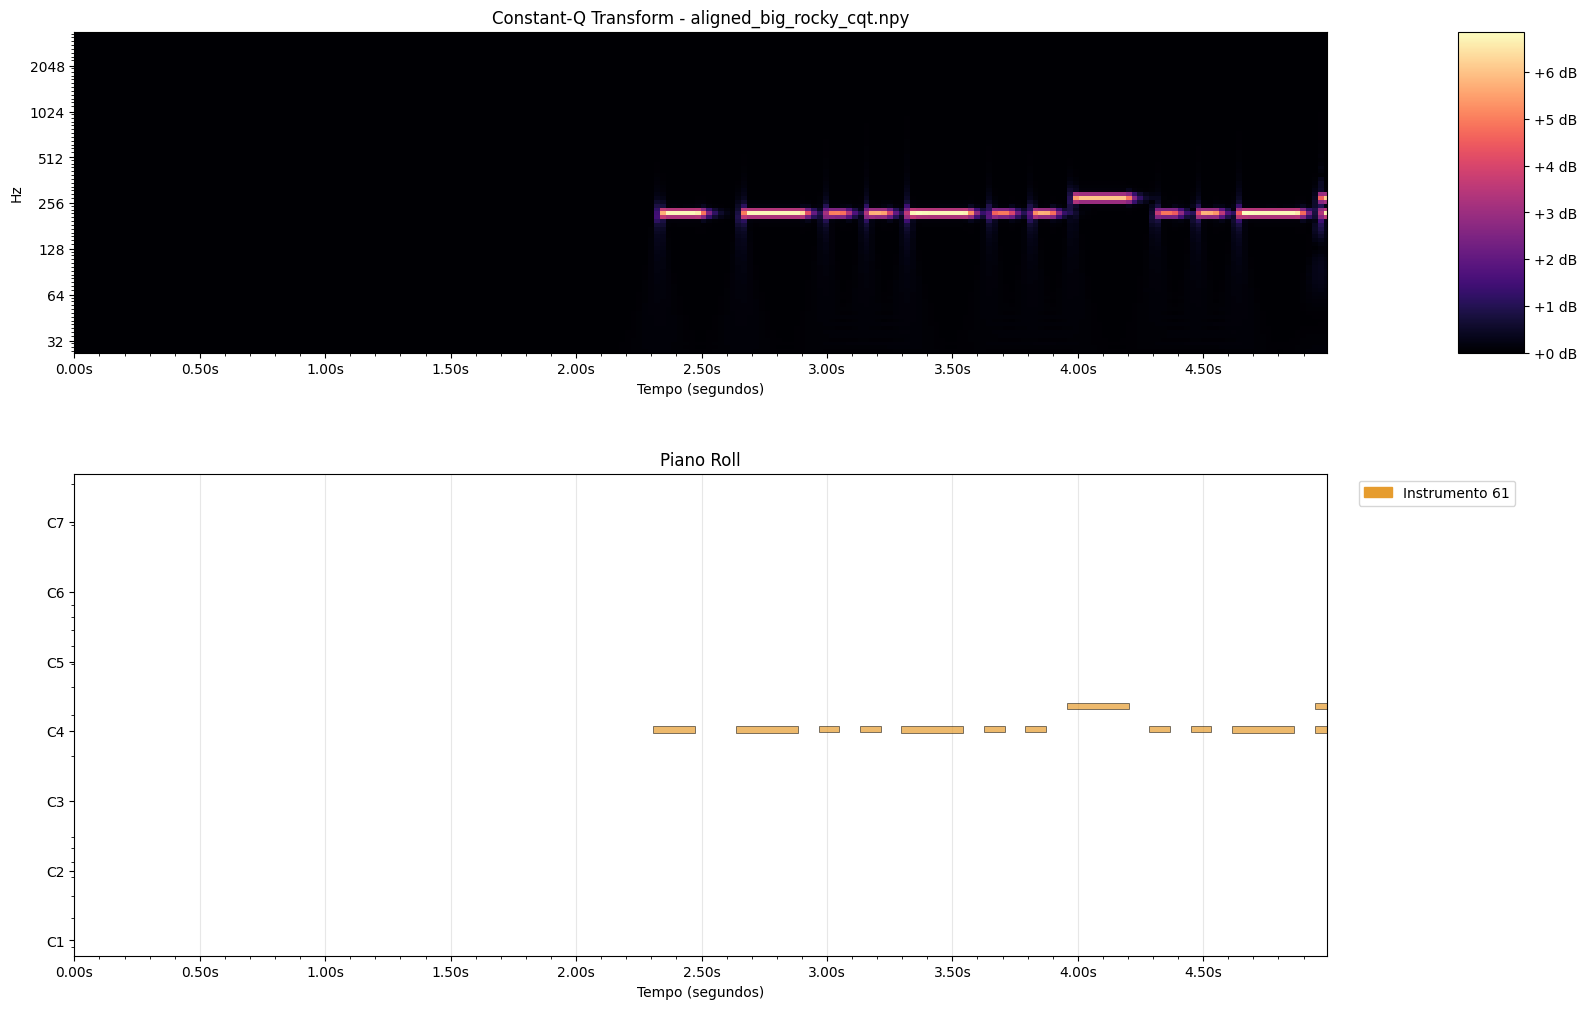

In [68]:
plot_cqt_and_midi("aligned_big_rocky_cqt.npy", tokens, start_time_seconds=0, end_time_seconds=5.0)